In [111]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from matplotlib import pyplot
np.random.seed(2017) # set random seed value to get reproducible results

In [112]:
# store start time to get execution time of entire script
start_time = time.time()

### Load Data

In [113]:
df = pd.read_csv('data_cleaned.csv', index_col=[0])
df.drop(columns=['ada_0_cd'], inplace=True) # temporary!!!
print(df.shape)
df.head()

(5457, 39)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,primsev_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,...,SFSg_0_cd,Raceg4_cd_1,Raceg4_cd_2,Raceg4_cd_3,Raceg4_cd_4,loc_cd_1,loc_cd_2,loc_cd_3,loc_cd_6,loc_cd_9
0,1,1,0,0,1,2,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,2,0,1,1,0,...,1,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,2,0,0,2,0,...,0,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,2,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,2,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


### Split Data by Substance

In [114]:
opioids_mask = df['primsev_cd'] == 5
opioids = df[opioids_mask]
opioids = opioids.drop(columns=['primsev_cd'])

amphetamines_mask = df['primsev_cd'] == 2
cocaine_mask = df['primsev_cd'] == 4
stimulants = df[amphetamines_mask | cocaine_mask]
stimulants = stimulants.drop(columns=['primsev_cd'])

print('Opioids:', opioids.shape)
print('Stimulants:', stimulants.shape)

Opioids: (933, 38)
Stimulants: (4524, 38)


### Outcome Distribution (percentage)

In [115]:
stimulants['init'].value_counts() / stimulants['init'].shape[0] * 100

1    88.859416
0    11.140584
Name: init, dtype: float64

In [116]:
opioids['init'].value_counts() / opioids['init'].shape[0] * 100

1    88.960343
0    11.039657
Name: init, dtype: float64

In [117]:
stimulants['engage30'].value_counts() / stimulants['engage30'].shape[0] * 100

1    63.218391
0    36.781609
Name: engage30, dtype: float64

In [118]:
opioids['engage30'].value_counts() / opioids['engage30'].shape[0] * 100

1    70.418006
0    29.581994
Name: engage30, dtype: float64

### Modelling

In [119]:
def run_model(model, data, grouping, outcome):
    X = data.drop(columns=[outcome])
    y = data[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)    
    
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5)
    top_model_ind = list(res['test_score']).index(max(list(res['test_score'])))
    model = res['estimator'][top_model_ind]
    
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    # https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    try:
        # random forest
        feature_importance = model.feature_importances_ 
        label = "RF " + grouping + " " + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(model.coef_[0]) # hazard ratios
        label = "LR " + grouping + " " + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('AUC: %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(label)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    features = X.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df

In [120]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    outcomes = ["init", "engage30", "ada_0_cd"] # ada_0_cd is continuous
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all() and col not in outcomes: # if non-binary and not an outcome
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    #print('Logistic Regression Features:',lasso_X.columns)
    return result

In [121]:
opioids_engage30 = opioids.drop(columns=['init'])
opioids_init = opioids.drop(columns=['engage30'])
stimulants_engage30 = stimulants.drop(columns=['init'])
stimulants_init = stimulants.drop(columns=['engage30'])

In [122]:
features_random_forest = list(opioids_engage30.columns)
features_random_forest.remove('engage30')
feature_importance_random_forest = pd.DataFrame({"feature": features_random_forest})
feature_importance_random_forest = feature_importance_random_forest.set_index('feature')


features_logistic_regression = list(get_logistic_regression_features(opioids_engage30).columns)
features_logistic_regression.remove('engage30')
feature_importance_logistic_regression = pd.DataFrame({"feature": features_logistic_regression})
feature_importance_logistic_regression = feature_importance_logistic_regression.set_index('feature')

X_train: (3031, 36) X_test: (1493, 36) y_train: (3031,) y_test: (1493,)
Accuracy: 0.8868050904219692
F1: 0.9399217916814788
Precision: 0.8896366083445492
Recall: 0.9962321024868124
AUC: 0.691


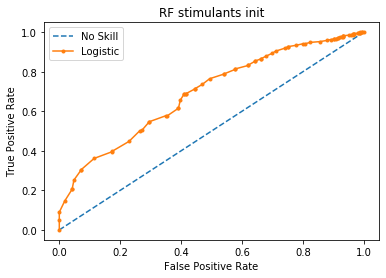

In [123]:
random_forest_stimulants_init = run_model(RandomForestClassifier(), stimulants_init, 'stimulants', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_init)

X_train: (3031, 52) X_test: (1493, 52) y_train: (3031,) y_test: (1493,)
Accuracy: 0.8881446751507033
F1: 0.9406749555950267
Precision: 0.8879946344735077
Recall: 1.0
AUC: 0.682


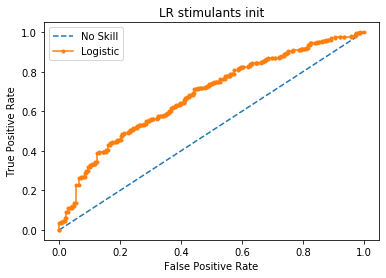

In [124]:
stimulants_init_logistic_regression = get_logistic_regression_features(stimulants_init)

logistic_regression_stimulants_init = run_model(LogisticRegression(max_iter=1000), stimulants_init_logistic_regression, 'stimulants', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_init)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.8896103896103896
F1: 0.9415807560137456
Precision: 0.8925081433224755
Recall: 0.9963636363636363
AUC: 0.619


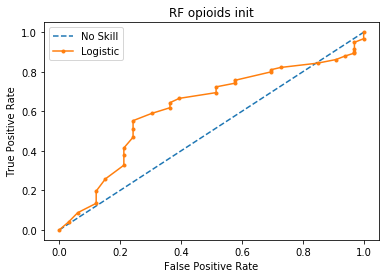

In [125]:
random_forest_opioids_init = run_model(RandomForestClassifier(), opioids_init, 'opioids', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_init)

X_train: (625, 52) X_test: (308, 52) y_train: (625,) y_test: (308,)
Accuracy: 0.8993506493506493
F1: 0.9466437177280551
Precision: 0.9166666666666666
Recall: 0.9786476868327402
AUC: 0.704


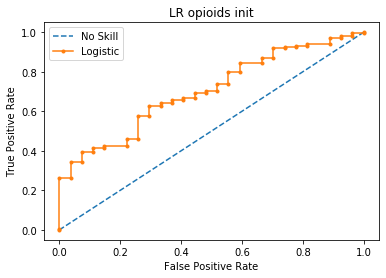

In [126]:
opioids_init_logistic_regression = get_logistic_regression_features(opioids_init)

logistic_regression_opioids_init = run_model(LogisticRegression(max_iter=1000), opioids_init_logistic_regression, 'opioids', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_init)

X_train: (3031, 36) X_test: (1493, 36) y_train: (3031,) y_test: (1493,)
Accuracy: 0.6543871399866041
F1: 0.7628676470588235
Precision: 0.6720647773279352
Recall: 0.8820403825717322
AUC: 0.620


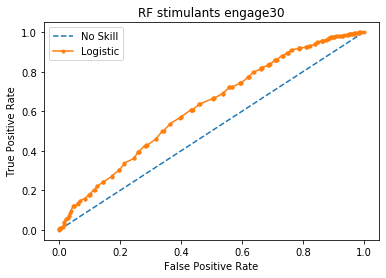

In [127]:
random_forest_stimulants_engage30 = run_model(RandomForestClassifier(), stimulants_engage30, 'stimulants', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_engage30)

X_train: (3031, 52) X_test: (1493, 52) y_train: (3031,) y_test: (1493,)
Accuracy: 0.6403215003348962
F1: 0.7560199909132213
Precision: 0.6566692975532754
Recall: 0.8907922912205567
AUC: 0.596


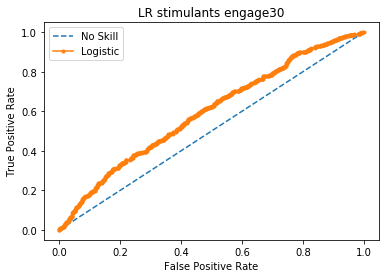

In [128]:
stimulants_engage30_logistic_regression = get_logistic_regression_features(stimulants_engage30)

logistic_regression_stimulants_engage30 = run_model(LogisticRegression(max_iter=1000), stimulants_engage30_logistic_regression, 'stimulants', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_engage30)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.6818181818181818
F1: 0.7949790794979079
Precision: 0.7251908396946565
Recall: 0.8796296296296297
AUC: 0.605


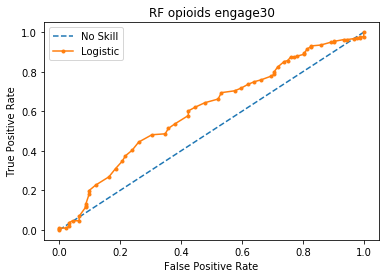

In [129]:
random_forest_opioids_engage30 = run_model(RandomForestClassifier(), opioids_engage30, 'opioids', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_engage30)

X_train: (625, 52) X_test: (308, 52) y_train: (625,) y_test: (308,)
Accuracy: 0.7077922077922078
F1: 0.8170731707317074
Precision: 0.7335766423357665
Recall: 0.9220183486238532
AUC: 0.640


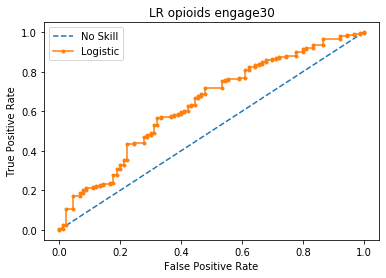

In [130]:
opioids_engage30_logistic_regression = get_logistic_regression_features(opioids_engage30)

logistic_regression_opioids_engage30 = run_model(LogisticRegression(max_iter=1000), opioids_engage30_logistic_regression, 'opioids', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_engage30)

### Feature Importance Analysis

In [131]:
def func(row, groups):
    result = 0
    for group in groups:
        result += abs(row[group])
    return result

feature_importance_random_forest['abs sum'] = feature_importance_random_forest.apply(lambda row: func(row, feature_importance_random_forest.columns), axis=1)
feature_importance_random_forest = feature_importance_random_forest.sort_values(by='abs sum', ascending=False)

feature_importance_logistic_regression['abs sum'] = feature_importance_logistic_regression.apply(lambda row: func(row, feature_importance_logistic_regression.columns), axis=1)
feature_importance_logistic_regression = feature_importance_logistic_regression.sort_values(by='abs sum', ascending=False)

In [132]:
feature_importance_random_forest.head() 

,RF stimulants init,RF opioids init,RF stimulants engage30,RF opioids engage30,abs sum
feature,,,,,
cjsig_0_cd,0.052517,0.048274,0.044891,0.048703,0.194385
SFSg_0_cd,0.038567,0.046523,0.039247,0.070018,0.194353
gcsg_0_cd,0.044396,0.047158,0.040869,0.042850,0.175273
TMIg_0_cd,0.044385,0.050201,0.041951,0.035242,0.171778
adhdg_0_cd,0.044135,0.047865,0.040220,0.039052,0.171273


In [133]:
feature_importance_logistic_regression.head(10) 

,LR stimulants init,LR opioids init,LR stimulants engage30,LR opioids engage30,abs sum
feature,,,,,
loc_cd_1,4.010776,2.667209,1.297580,0.572800,8.548366
CWSg_0_cd_2,4.274559,1.515337,0.893948,0.929257,7.613100
dldiag_cd,1.275755,2.686665,1.194246,1.857169,7.013834
adhdg_0_cd_0,1.384033,1.825633,1.224525,1.455413,5.889604
TRIg_0_cd_0,1.385317,2.136414,1.114330,0.939266,5.575327
loc_cd_9,0.476615,0.521861,2.075363,2.495880,5.569719
TRIg_0_cd_2,1.649525,0.954259,1.419190,1.531622,5.554596
lrig_0_cd_0,1.326750,1.472929,0.773050,1.681729,5.254458
homeless_0_cd,1.515275,1.477952,1.201564,1.048173,5.242964


In [134]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feature_importance_random_forest.to_excel(writer, sheet_name='Random Forest')
feature_importance_logistic_regression.to_excel(writer, sheet_name='Logistic Regression')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [135]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 12 seconds ---


In [136]:
# notes

# distribution of engage30 is better (~60% positive rate) than init (~90% positive rate)
# based on the low coefficients for all the features for init predictions it looks like the 
#   model is always predicting the same thing
# engage30 dominates feature importance